# Data Cleaning and EDA #
The script has gathered up to 100 reviews per user for almost 300 users. Time to make sure all the data is present

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# File path to the consolidated data
path = '../data/interim/consolidated_data.csv'

In [3]:
df = pd.read_csv(path)
df.head()

,title,author,avg_rating,user_rating,cover_url,user_id
0,Remarkable Women of California,"DeYoung, Marilyn Brant Chandler",4.75,5,https://i.gr-assets.com/images/S/compressed.ph...,1
1,"Harry Potter Series Box Set (Harry Potter, #1-7)","Rowling, J.K.",4.74,5,https://i.gr-assets.com/images/S/compressed.ph...,1
2,Conartist: Paul Conrad 30 Years with The Los A...,"Corwin, Norman",4.71,5,https://i.gr-assets.com/images/S/compressed.ph...,1
3,The Indispensable Calvin and Hobbes,"Watterson, Bill",4.70,5,https://i.gr-assets.com/images/S/compressed.ph...,1
4,The Authoritative Calvin and Hobbes: A Calvin ...,"Watterson, Bill",4.70,5,https://i.gr-assets.com/images/S/compressed.ph...,1


In [4]:
df.shape

(29032, 6)

In [5]:
df['title'].nunique()

20581

In [6]:
df['cover_url'].nunique()

21321

In [7]:
df.isna().sum()

title          0
author         0
avg_rating     0
user_rating    0
cover_url      0
user_id        0
dtype: int64

In [8]:
df.user_id.unique().dtype

dtype('int64')

In [9]:
non_integers = df[pd.to_numeric(df['user_id'], errors='coerce').isna()]
print(non_integers)

Empty DataFrame
Columns: [title, author, avg_rating, user_rating, cover_url, user_id]
Index: []


### First Impressions ###
There are 29,032 reviews here, and 20,581  unique books. I'm glad to see this much variety.Hopefully I don't end up recommending too many obscure books. There are more unique cover URLs due to different editions existing for many of the books.

# SQL Database Exploration #
Now I want to check out the relational database I made from the data

In [10]:
database_path = os.path.abspath(
            os.path.join(
                os.pardir,
                'data',
                'processed',
                'books.db'
                )
            )

conn = sqlite3.connect(database_path)

In [11]:
cur = conn.cursor()
cur.execute('SELECT * FROM Ratings LIMIT 10')
results = cur.fetchall()

for row in results:
    print(row)

(1, 1, 5, 4.75)
(1, 2, 5, 4.74)
(10553671, 2, 4, 4.74)
(111921, 2, 5, 4.74)
(2294090, 2, 5, 4.74)
(2431437, 2, 5, 4.74)
(25184600, 2, 3, 4.74)
(2612079, 2, 4, 4.74)
(28798380, 2, 0, 4.74)
(3078602, 2, 5, 4.74)


In [12]:
cur = conn.cursor()
cur.execute('SELECT * FROM Books LIMIT 10')
results = cur.fetchall()

for row in results:
    print(row)

(1, 'Remarkable Women of California', 'DeYoung, Marilyn Brant Chandler', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1453769226l/28699343._SX50_.jpg')
(2, 'Harry Potter Series Box Set (Harry Potter, #1-7)', 'Rowling, J.K.', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1534298934l/862041._SX50_.jpg')
(3, 'Conartist: Paul Conrad 30 Years with The Los Angeles Times', 'Corwin, Norman', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1349036388l/411703._SX50_.jpg')
(4, 'The Indispensable Calvin and Hobbes', 'Watterson, Bill', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1347311516l/24815._SX50_.jpg')
(5, 'The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury', 'Watterson, Bill', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1391114055l/59715._SY75_.jpg')
(6, 'Homicidal Psycho Jungle Cat (Calvin and Hobbes, #9)', 'Watterson, Bill', 'https://i.gr-assets.co

In [13]:
cur.execute('SELECT COUNT(*) FROM Books')
book_count = cur.fetchone()
print(book_count)

(20642,)


In [14]:
cur.execute('SELECT COUNT(*) FROM Users')
user_count = cur.fetchone()
print(user_count)

(293,)


In [15]:
for row in conn.execute('PRAGMA table_info(Ratings)'):
    print(row)

(0, 'user_id', 'INTEGER', 0, None, 0)
(1, 'book_id', 'INTEGER', 0, None, 0)
(2, 'user_rating', 'INTEGER', 0, None, 0)
(3, 'avg_rating', 'REAL', 0, None, 0)


### Database Assessment ###
The database is correctly built with all books, users, and ratings accounted for! There are 20,642 unique combinations of book title and cover URL. While I'd like to go through and merge all unique editions into a single entry, I don't expect it would be worth the effort for the purposes of this project.

## EDA ##
Now I want to take a look at the distributions of books and ratings.

### Most Popular Books ###

In [16]:
query = '''
SELECT b.title, AVG(r.avg_rating) as avg_rating, COUNT(r.user_rating) as votes
FROM Books b
JOIN Ratings r ON b.book_id = r.book_id
GROUP BY b.title
'''
books_avg_ratings_df = pd.read_sql_query(query, conn)

In [17]:
books_avg_ratings_df.sort_values(by = ['votes', 'avg_rating'], ascending = [False, False]).head(10)

,title,avg_rating,votes
6716,Harry Potter and the Deathly Hallows (Harry Po...,4.62,119
6728,Harry Potter and the Prisoner of Azkaban (Harr...,4.58,115
6718,Harry Potter and the Goblet of Fire (Harry Pot...,4.56,108
6719,Harry Potter and the Half-Blood Prince (Harry ...,4.58,82
6731,Harry Potter and the Sorcerer's Stone (Harry P...,4.47,79
6722,Harry Potter and the Order of the Phoenix (Har...,4.50,75
6714,Harry Potter and the Chamber of Secrets (Harry...,4.43,61
17285,"The Return of the King (The Lord of the Rings,...",4.56,53
327,"A Game of Thrones (A Song of Ice and Fire, #1)",4.44,51
222,A Court of Mist and Fury (A Court of Thorns an...,4.64,41


The most popular books are, unsurprisingly, the Harry Potter series. Then I see some titles from other fantasy series like A song of Ice and Fire and The Lord of the Rings.

In [18]:
ratings_df = pd.read_sql_query('SELECT * FROM Ratings', conn)
ratings_df.head()

,user_id,book_id,user_rating,avg_rating
0,1,1,5,4.75
1,1,2,5,4.74
2,10553671,2,4,4.74
3,111921,2,5,4.74
4,2294090,2,5,4.74


### Least Popular Books ###
Although I sorted each user's shelf by most popular books, I'm curious to know which are the least popular books in the dataset.

In [19]:
num_reviews = ratings_df['book_id'].value_counts()
len(num_reviews.unique())

47

In [20]:
len(ratings_df['book_id'].unique())

20642

There are 37 unique value counts, so if I make a histogram with 102 bins, each bin will account for a distinct value count. This way I can see the distribution of book popularity.

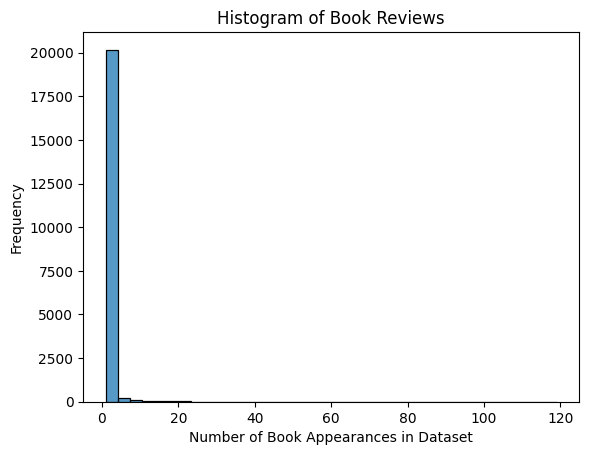

In [21]:
sns.histplot(data = num_reviews, bins = 37)
plt.title('Histogram of Book Reviews')
plt.xlabel('Number of Book Appearances in Dataset')
plt.ylabel('Frequency')
plt.show()

Over 20,000 of the 21,892 unique books only appear once in the dataset. I wonder how many books would remain if I dropped all books with fewer than 10 appearances.

In [22]:
min_books = 10
popular_filter = ratings_df['book_id'].value_counts() > min_books
popular_filter = popular_filter[popular_filter].index.to_list()
popular_df = ratings_df[ratings_df['book_id'].isin(popular_filter)]
len(popular_df['book_id'].value_counts().unique())

37

Only 37 books remain if I filter out the books with fewer than 10 reviews. I don't think this is a good idea. If I was starting with a much larger dataset I could make the argument for this approach, but I have too few books to eliminate most of them.

### User Rating Distribution ###
Now I want to see if user ratings are distributed normally.

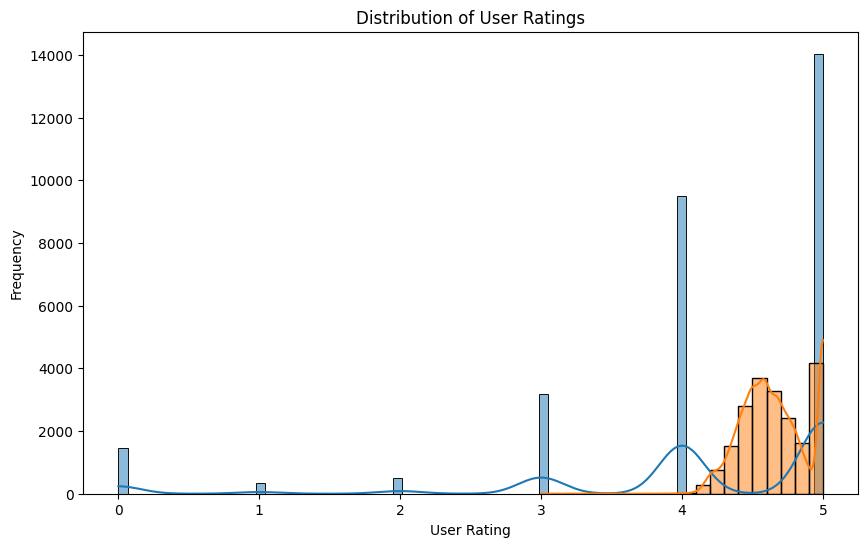

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['user_rating'], kde = True)
sns.histplot(books_avg_ratings_df['avg_rating'], kde = True, bins = 20)
plt.title('Distribution of User Ratings')
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.show()

The above histograms show the distribution of user ratings in blue and the distribution of average ratings in orange. It is not surprising that the most popular users would give the most popular books a high rating generally. I am a little surprised that these users give out so many 5-star reviews. While it is very subjective, many Goodreads users adhere to the same rating scale, where a 5-star rating is reserved for the user's favorite books of all time. But I suppose that popular, well-reviewed books are exactly that for a reason. The median book in this dataset has an average rating of just over 4 stars. The distribution of average ratings has a longer tail on the left, which makes sense due to the cap at 5 stars. I'm a little surprised to see that some of the books on this list managed to be popular enough but also average fewer than 3 stars.

In [24]:
query = '''
SELECT user_id, AVG(user_rating) as user_avg_rating
FROM Ratings r
GROUP BY user_id
'''
user_avg_ratings_df = pd.read_sql_query(query, conn)

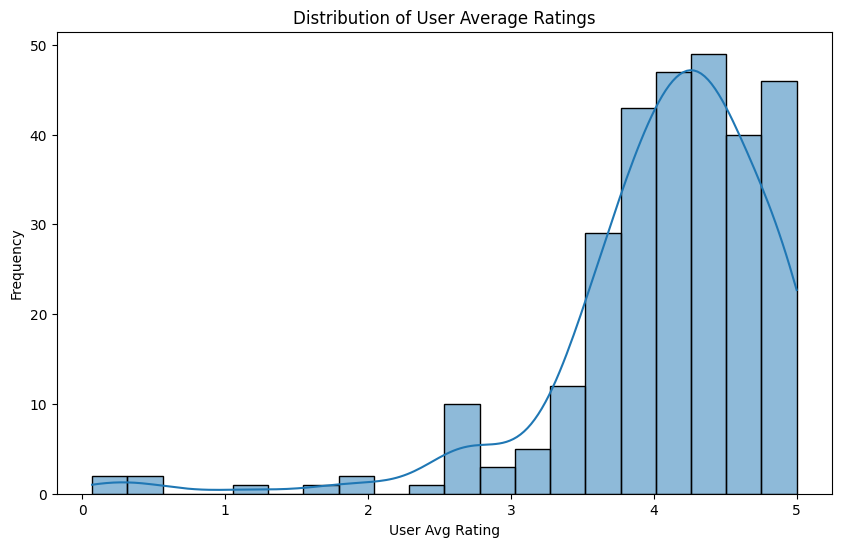

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings_df['user_avg_rating'], kde = True, bins = 20)
plt.title('Distribution of User Average Ratings')
plt.xlabel('User Avg Rating')
plt.ylabel('Frequency')
plt.show()

This histogram plot shows the distribution of each user's average rating. Some users clearly love the popular books, giving out an average of almost 5 stars. Many users are clustered around the 4-star average rating. Some users, on the other hand, seem to be haters and give out generally very low scores. I'll check those users out.

### Low-Rater Investigation ###
I'll take a look at a particular user who gives out very low scores on average.

In [26]:
query = '''
SELECT user_id, SUM(user_rating == 0) AS zero_star, SUM(user_rating == 1) AS one_star, SUM(user_rating == 2) AS two_star,
SUM(user_rating == 3) AS three_star, SUM(user_rating == 4) AS four_star,
SUM(user_rating == 5) AS five_star, 
AVG(user_rating) AS user_avg
FROM Ratings r
GROUP BY user_id
HAVING AVG(user_rating) < 3
'''

low_ratings_df = pd.read_sql_query(query, conn)

In [27]:
low_ratings_df

,user_id,zero_star,one_star,two_star,three_star,four_star,five_star,user_avg
0,914795,0,12,39,26,23,0,2.600000
1,922495,47,0,0,1,1,51,2.620000
2,1005037,30,0,0,13,33,24,2.910000
3,1113032,47,0,0,21,19,13,2.040000
4,1162953,4,4,33,44,13,2,2.640000
5,1323157,34,1,2,14,36,13,2.560000
6,3734681,62,0,0,4,14,20,1.680000
7,4717304,32,0,5,10,31,22,2.740000
8,5451550,98,0,0,1,1,0,0.070000
9,7205303,95,0,0,0,2,3,0.230000


Right away I can see some users rarely rate books, often just logging them as "read" without assigning a score. These are users which I would likely drop from the training data if I refined my model further. As it stands, I'll keep them since I don't have a trememndously large dataset to begin with. I'm more intrigued by the users who score each book but are very stingy with high scores. User 3258178 for instance has no zeros and only 9 fives. They mostly rate books either 2 or 3 stars. 

In [28]:
query = '''
SELECT r.user_id, b.title, r.user_rating, r.avg_rating 
FROM Ratings r
JOIN Books b ON b.book_id = r.book_id
WHERE user_id == 3258178
'''

user_3258178_df = pd.read_sql_query(query, conn)

In [29]:
differenced_df = user_3258178_df.assign(diff = (user_3258178_df['user_rating']) - user_3258178_df['avg_rating'])
differenced_df.sort_values(by = 'diff', ascending = False)

,user_id,title,user_rating,avg_rating,diff
90,3258178,"Take Back the Night (Jim Hollister, #3)",5,4.40,0.60
97,3258178,Slightly out of Focus,5,4.40,0.60
85,3258178,Locas,5,4.41,0.59
75,3258178,Love & Rockets Vol. 3: Las mujeres perdidas,5,4.42,0.58
79,3258178,Vietnam,5,4.42,0.58
...,...,...,...,...,...
78,3258178,"Band Of Brothers: E Company, 506th Regiment, 1...",2,4.42,-2.42
3,3258178,Roots: The Saga of an American Family,2,4.44,-2.44
35,3258178,God Cried,2,4.50,-2.50
89,3258178,The Great War For Civilisation: The Conquest o...,0,4.40,-4.40


In [30]:
differenced_df['diff'].loc[differenced_df['diff'] > 0].count()

22

In [31]:
user_avg = np.mean(differenced_df['user_rating'])
goodreads_avg = np.mean(differenced_df['avg_rating'])
diff_avg = np.mean(differenced_df['diff'])
print(f"The User averages a score of {user_avg} stars compared to a Goodreads average of \
{goodreads_avg:0.2f} stars\n for books in the user's library. This is an average differential of \
{diff_avg:0.2f} stars.")

The User averages a score of 3.7 stars compared to a Goodreads average of 4.50 stars
 for books in the user's library. This is an average differential of -0.80 stars.


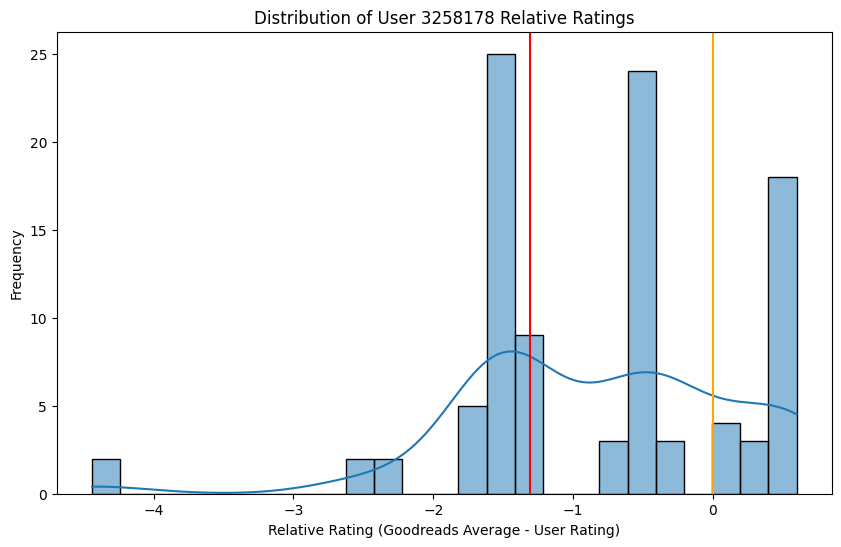

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(differenced_df['diff'], kde = True, bins = 25)
plt.axvline(0, 0, 1, color = 'orange')
plt.axvline(-1.31, 0, 1, color = 'red')
plt.title('Distribution of User 3258178 Relative Ratings')
plt.xlabel('Relative Rating (Goodreads Average - User Rating)')
plt.ylabel('Frequency')
plt.show()

This particular user is  particularly strict with their ratings. The user averages a rating of 2.76 stars, which is over a full star less than the average Goodreads rating for the books in their library. They have rated plenty of books above the Goodreads average, so I wouldn't consider them a hater. They just tend not to love the most popular books.

User 77805119 doesn't merit much analysis. They seem to treat the ratings as binary, rating most books either 0 or 5 stars. This could be good feedback for a model, equating to either a "yes" or "no" recommendation.

In [33]:
conn.close()

# Conclusion #
This exploration has shown me that the most popular Goodreads users do not have a uniform system for rating books. Many of them use a similar scale : 
* 1 star - I did not like it
* 2 stars - It was fine
* 3 stars - I liked it
* 4 stars - I really liked it

Other users rate very differently. The model will have to account for these variations as it learns how to recommend books based on user similarity scores..